In [5]:
# Pixel-based UAV-RGB coastal wetland vegetation classification in Geemap
# 
# 1.import GEE-python environment
# 2.load UAV data and training and validation samples
# 3.Visualize the imported data in the local geemap
# 4.Feature extraction for UAV-RGB images to construct classification dataset
# 5.Pixel-based(PB) Classificaition
#
# Time: 2022-10
#
# E-mail: 19210700109@fudan.edu.cn

In [ ]:
# 1.import GEE-python environment
import ee
import geemap 
import pandas as pd 
import numpy as np
import csv
import os
import time 
from datetime import date

# Initialize GEE
ee.Initialize()
Map = geemap.Map(center=[40,-100], zoom=4)

In [6]:
# 2.load UAV data and training and validation samples
# load feature file
tif5_shp = ee.FeatureCollection('projects/master-cozyzheng/assets/tif5_shp_0910')
shp = tif5_shp.geometry()
scale_UAV = 0.04168

# load UAV-raster
tif4 = ee.Image('users/cozyzheng/tif4')
tif5_new = ee.Image('projects/master-cozyzheng/assets/tif5_mask')

# load UAV-derived Digital surface model(DSM)
tif5_dsm = ee.Image('projects/master-cozyzheng/assets/dsm_tif5')
tif5_dsm = tif5_dsm.select(['b1']).rename(['dsm'])

# load the label
label_1 = ee.Image('projects/master-cozyzheng/assets/1_geo_label')
label_2 = ee.Image('projects/master-cozyzheng/assets/2_geo_label')
label_6 = ee.Image('projects/master-cozyzheng/assets/6_geo_label')
label_7 = ee.Image('projects/master-cozyzheng/assets/7_geo_label')

In [7]:
# 3.Visualize the imported data in the local geemap
# Visualization settings of raster.
vis = {
    'bands': ['b1', 'b2', 'b3'], 
    'gamma': 1.3,
    'min': 0, 'max': 256
}
Map.addLayer(tif1, vis, 'tif1')
Map.addLayer(tif2, vis, 'tif2')
Map.addLayer(tif4, vis, 'tif4')
Map.addLayer(tif5_new, vis, 'tif5')

# Visualization settings of label.
vis_label = {
    'palette':['c1ed0e','1f78b4','33a02c','a6cee3','fb9a99'],
    'min': 0, 'max': 4
}

# Visualization
Map.addLayer(label_1,vis_label, 'label_1')
Map.addLayer(label_2,vis_label, 'label_2')
Map.addLayer(label_5,vis_label, 'label_5')
Map.centerObject(tif5_dsm,16)
# Map

In [8]:
# 4. Feature extraction for UAV-RGB images to construct classification dataset
# 1) Extract GLCM(Gray-level co-occurrencematrix) texture features.
# 2) Extract spectral features; RGB-based spectral index
# 3) Merge DSM data of UAV-RGB data, DSM data is automatically generated by DJI GS Pro when generating RGB data

def glcm_add(image):
    '''
    1) Calculate the RGB band for grays according to the luma principle
    2) Calculate GLCM by gray bands
    3) Add the relevant texture indices to the image
    '''
    # Read the bands in image
    R = image.select('b1')
    G = image.select('b2')
    B = image.select('b3')
    
    # Gray,the rec601 luma (Y′) com ponent
    Gray=R.multiply(0.299).add(G.multiply(0.587)).add(B.multiply(0.114)).toUint8()

    # Band renaming 
    image = image.select(['b1','b2','b3']).rename(['r','g','b'])
    Gray = geemap.rename_bands(Gray, ['b1'], ['gray'])
    
    # Cat the gray
    image = ee.Image.cat(Gray, image)
        
    # Calculating GLCM texture features 
    glcm = image.select('gray').toUint8().glcmTexture()
    
    # Merge rgb and GLCM bands
    data=ee.Image.cat(image,glcm.select(['gray_asm','gray_contrast','gray_corr',
                                         'gray_ent','gray_var','gray_idm','gray_savg']))
    return data, Gray


def rgb_index_add(image):
    '''
    Extract the RGB bands in the image and apply ee.Image().expression
    to calculate the relevant RGB vegetation spectral indices in the UAV-RGB image
    '''
    R = image.select('r')
    G = image.select('g')
    B = image.select('b')
    
    # Calculate the relevant RGB indices and rename them in the generated bands
    ExGI = ee.Image().expression('2 * G -(R + B)',
                               {'R': R,'G': G,'B': B})
    ExGI = ExGI.select(['constant']).rename(['exgi'])

    GCC = ee.Image().expression('G / (R + G + B)',
                               {'R': R,'G': G,'B': B})
    GCC = GCC.select(['g']).rename(['gcc'])

    GRVI = ee.Image().expression('(G - R)/(G + R)',
                               {'R': R,'G': G})
    GRVI = GRVI.select(['g']).rename(['grvi'])
    
    VDVI = ee.Image().expression('(2*G-R-B)/(2*G+R+B)',
                               {'G': G,'R': R,'B':B,})
    VDVI = VDVI.select(['constant']).rename(['vdvi'])
    
    NGBDI = ee.Image().expression('(G-B)/(G+B)',
                               {'G': G,'B':B})
    NGBDI = NGBDI.select(['g']).rename(['ngbdi'])
    

    # Combine the generated RGB indices into the image
    image = ee.Image.cat(ExGI,GCC,GRVI,VDVI,NGBDI,image)
    
    return image 

# 1）Calculate GLCM characteristics
tif5_add_glcm, tif5_gray= glcm_add(tif5_new)
# tif5_adde_glcm.getInfo()

# 2）Calculate RGB-based vegetation index
tif5_add_glcm_rgb = rgb_index_add(tif5_add_glcm) 

# 3）Merge DSM data
tif5_add_glcm_rgb_dsm = ee.Image.cat(tif5_add_glcm_rgb, tif5_dsm.select(['dsm']))

# Check the generated data
# tif5_add_glcm_rgb_dsm.getInfo()

In [10]:
#5. Pixel-based(PB) UAV-RGB coastal wetland vegetation classification:
#1) Random sampling in different labels to generate sample points;

#2) Single training, construction of training set and test set, prediction of the overall UAV image, 
# and analysis of relative importance of feature in random forests;

#3) Conduct multiple random sampling training, select different classifiers for multiple classification, 
# count the classification evaluation indicators of multiple training, and derive relevant data, prediction graph and confusion matrix.


# ----------------------------------------------------------------------------------------------
#1) Random sampling in different labels to generate sample points
def sample_point_gen_tif5(point = 5000, scale = scale_UAV):
    '''
    sample points with Geo-information are randomly generated
    '''
    number_sample = point
    random_seed = np.random.randint(0,100)

    points_1 =label_1.sample(**{
        'scale': scale,
        'numPixels': number_sample,
        'seed': random_seed,
        'geometries': True  
    })

    points_2 =label_2.sample(**{
        'scale': scale,
        'numPixels': number_sample,
        'seed': random_seed,
        'geometries': True  
    })


    points_6 =label_6.sample(**{
        'scale': scale,
        'numPixels': number_sample,
        'seed': random_seed,
        'geometries': True  
    })

    points_7 =label_7.sample(**{
        'scale': scale,
        'numPixels': number_sample,
        'seed': random_seed,
        'geometries': True  
    })

    points = points_1.merge(points_2).merge(points_6).merge(points_7)    
    return points

# 可视化样本点
# points = sample_point_gen()
# Map.addLayer(points, {}, 'data_point', False)
# Map

In [22]:
%%time
# 2) Single training, get sample points, construct training and test sets, and make predictions on the overall UAV image.
# a) Supervised classification step, at this point RF is selected as the classifier, using ee.Classifier.smileRandomForest

# Band selection
bands = ['r','g','b','exgi','gcc','grvi','ngbdi','vdvi',
         'gray_asm','gray_contrast','gray_corr',
    'gray_ent','gray_var','gray_idm','gray_savg','dsm']
# bands = ['r','g','b']

#------------------------------------------------------------------------
label = 'b1'
# Randomly generated sample points
points = sample_point_gen_tif5()

# Sampling on the original image to generate samples with labels
sample = tif5_add_glcm_rgb_dsm.select(bands).sampleRegions(**{
  'collection': points,
  'properties': [label]
#    ,'scale':0.04
})

# Splitting of training and validation sample points
split = 0.7
sample = sample.randomColumn()
training = sample.filter(ee.Filter.lt('random', split))
validation = sample.filter(ee.Filter.gte('random', split))

# Random forest classification
classifier = ee.Classifier.smileRandomForest(150).train(training, label, bands)

# prediction
result = tif5_add_glcm_rgb_dsm.select(bands).classify(classifier)
result = result.clip(shp)

# Visualization of results
Map.addLayer(result, vis_label, 'classfied')
Map
print('finished')

# tif5_add_glcm_rgb_dsm.getInfo()

finished
CPU times: user 19 ms, sys: 12.7 ms, total: 31.6 ms
Wall time: 2min 54s


In [23]:
# Exporting classification results
# geemap.ee_export_image_to_drive(result, description='0910_pb_predict',
#                             scale = 0.04,
#                             folder='gee_new',
#                             maxPixels=10000000000000, fileFormat='GeoTIFF') 

In [9]:
%%time
# b) Compute the confusion matrix on the validation set
validated = validation.classify(classifier)

# Generate confusion matrix
train_cm = classifier.confusionMatrix()
test_cm = validated.errorMatrix('b1', 'classification')

# Output Metrics
print('Acc:', test_cm.accuracy().getInfo())
print('Kappa:',test_cm.kappa().getInfo())
print('Producers Acc:',test_cm.producersAccuracy().getInfo())
print('cus Acc:',test_cm.consumersAccuracy().getInfo())

Acc: 0.8028228354750369
Kappa: 0.7265213355227095
Producers Acc: [[0.6912521440823327], [0.44933920704845814], [0.877720207253886], [0.7710960232783706], [0.8370901639344263]]
cus Acc: [[0.7964426877470355, 0.7034482758620689, 0.8482724086129194, 0.7763671875, 0.76]]
CPU times: user 54 ms, sys: 6.29 ms, total: 60.2 ms
Wall time: 1min 26s


In [11]:
# c) Exporting relevant data to local for subsequent analysis

# out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
# train_cm_csv = os.path.join(out_dir, 'train_cm_obia.csv')
# test_cm_csv = os.path.join(out_dir, 'test_cm_obia.csv')

# with open(train_cm_csv, "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerows(train_cm.getInfo())
    
# with open(test_cm_csv, "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerows(test_cm.getInfo())

,importance
dsm,3349.112998
ngbdi,2559.668976
gray_contrast,2515.484829
gray_corr,2486.194702
grvi,2475.631337
gray_savg,2457.298019
gray_var,2448.381300
gray_idm,2380.192641
gcc,2200.967331
vdvi,2176.272477


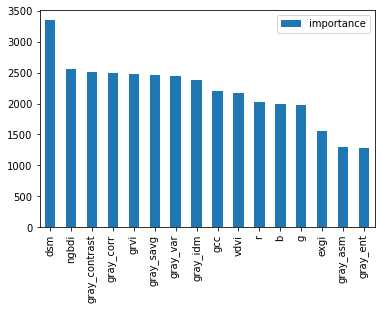

In [11]:
# d) Analysis of relative importance of feature in random forests

explain = classifier.explain()
var_im = ee.FeatureCollection(explain.get('importance'))
var_im_dict = var_im.getInfo()
var_im.getInfo()

# Normalization and visualization
df = pd.DataFrame.from_dict(var_im.getInfo(), orient='index')
df.rename(columns={0:'importance'},inplace= True)
df.sort_values(by = 'importance', ascending=False, inplace=True)

df.plot(kind= 'bar')
df

In [12]:
# Export to local
# df.to_csv(local_path.format(name_methods,date.today()), header=True, index=True,mode='a')  

In [11]:
# 3) Multiple random sample training, statistics of classification evaluation metrics, data, prediction maps, 
# confusion matrices for multiple training and export.
# a) Multiple random sampling training

def train_iterations_tif5(metrics, name_methods, iterations,
                          bands_selected,scale = scale_UAV,image = tif5_add_glcm_rgb_dsm):
    '''
    metrics: evaluating indicator
    name_methods: PB or OBIA
    iterations: iterations times
    bands_selected: band used in training 
    '''
    label = 'b1'
    bands = bands_selected
    df1 = metrics
    test_cm = [] 
    
    for i in range(iterations):

        # random_tree in random forest 
        # random_tree = np.random.randint(50,100)
        random_tree = 150 
        
        # Classification using the generated sample points
        points = sample_point_gen_tif5()
        sample = image.select(bands).sampleRegions(**{'collection': points,
                                                           'properties': [label],
                                                           'scale':scale})
        # Training, validation dataset splitting
        split = 0.7
        sample = sample.randomColumn()
        
        # Generate training and validation sets
        training = sample.filter(ee.Filter.lt('random', split))
        validation = sample.filter(ee.Filter.gte('random', split))

        # Random forest classification, other training methods can be added later
        classifier = ee.Classifier.smileRandomForest(random_tree).train(training, label, bands)

        # Predict and export results
        result = image.select(bands).classify(classifier)
        result_roi = result.clip(shp)
        
        # Validation
        validated = validation.classify(classifier)

        # Accuracy evaluation
        test_cm = validated.errorMatrix('b1', 'classification')
        oa = test_cm.accuracy().getInfo()
        kappa = test_cm.kappa().getInfo()
        ua = np.array(test_cm.consumersAccuracy().getInfo()).flatten()
        pa = np.array(test_cm.producersAccuracy().getInfo()).flatten()
        ua_mean = ua.mean()
        pa_mean = pa.mean()
        f_score = 2 * ua_mean * pa_mean/(ua_mean + pa_mean)

        # Statistics and analysis of relevant accuracy indicators for each class
        ua_1 = ua[0]
        ua_2 = ua[1]
        ua_3 = ua[2]
        ua_4 = ua[3]
        ua_5 = ua[4]

        pa_1 = pa[0]
        pa_2 = pa[1]
        pa_3 = pa[2]
        pa_4 = pa[3]
        pa_5 = pa[4]

        new = pd.DataFrame({'Methods':name_methods,'OA':oa,'Kappa':kappa,'scale':scale,
                            'UA_mean':ua_mean,'PA_mean':pa_mean, 'F-score':f_score,
                                    'UA_1':ua_1,'UA_2':ua_2,'UA_3':ua_3,'UA_4':ua_4,'UA_5':ua_5,
                                    'PA_1':pa_1,'PA_2':pa_2,'PA_3':pa_3,'PA_4':pa_4,'PA_5':pa_5},
                           index = [i])
        df1 = df1.append(new, ignore_index= True)
        # print('Epoch Finished, Df Added!')
        
        # Buffer to prevent the GEE server from stopping due to too much computing and reporting errors
        # time.sleep(120)
        
    cm = pd.DataFrame(test_cm.getInfo())
    print('Loop Finished, Df Added!')
    return df1, cm, result_roi

def savedata(name_methods,df, cm, result_roi):
    df.to_csv(local_path.format(name_methods, header=True, index=False,mode='a')) 
#     cm.to_csv(ocal_path.format(name_methods))
#     geemap.ee_export_image_to_drive(result_roi , description='NEW_{}'.format(name_methods),
#                             scale = scale_UAV,
#                             folder='gee_new',
#                             maxPixels=10000000000000, fileFormat='GeoTIFF')
    print('{}_Data saved!'.format(name_methods))
    pass 


In [ ]:
# b) Statistical multiple training of classification evaluation metrics, 
# data, prediction map, confusion matrix derived.

metrics = pd.DataFrame([], columns=['Methods','OA','F-score','UA_mean','PA_mean',
                                'UA_1','UA_2','UA_3','UA_4','UA_5',
                                'PA_1','PA_2','PA_3','PA_4','PA_5','Kappa','scale'])
iterations = 20
df = []
# original RGB
name_methods = 'PB_RGB'
bands = ['r','g','b']
df,cm, result= train_iterations_tif5(metrics, name_methods, iterations, bands,image = tif5_add_glcm_rgb_dsm)
savedata(name_methods,df, cm, result)

# RGB + Spectral Index
name_methods = 'PB_RGB_index'
bands = ['r','g','b',
         'exgi','gcc','grvi','ngbdi','vdvi']
df,cm, result= train_iterations_tif5(metrics, name_methods, iterations, bands,image = tif5_add_glcm_rgb_dsm)
savedata(name_methods,df, cm, result)

# RGB + Texture features
name_methods = 'PB_GLCM'
bands = ['r','g','b',
         'gray_asm','gray_contrast','gray_corr',
         'gray_ent','gray_var','gray_idm','gray_savg']
df,cm, result= train_iterations_tif5(metrics, name_methods, iterations, bands,image = tif5_add_glcm_rgb_dsm)
savedata(name_methods,df, cm, result)

# RGB + DSM
name_methods = 'PB_RGB_DSM'
bands = ['r','g','b','dsm']
df,cm, result= train_iterations_tif5(metrics, name_methods, iterations, bands,image = tif5_add_glcm_rgb_dsm)
savedata(name_methods,df, cm, result)

# RGB + Spectral Index + Texture features
name_methods = 'PB_RGB_index_GLCM'
bands = ['r','g','b',
         'exgi','gcc','grvi','ngbdi','vdvi',
         'gray_asm','gray_contrast','gray_corr',
         'gray_ent','gray_var','gray_idm','gray_savg'] 
df,cm, result= train_iterations_tif5(metrics, name_methods, iterations, bands,image = tif5_add_glcm_rgb_dsm)
savedata(name_methods,df, cm, result)

# RGB + Spectral Index + Texture features + Digital surface model
name_methods = 'PB_RGB_index_GLCM_DSM'
bands = ['r','g','b',
         'exgi','gcc','grvi','ngbdi','vdvi',
         'gray_asm','gray_contrast','gray_corr',
         'gray_ent','gray_var','gray_idm','gray_savg',
         'dsm'] 
df,cm, result= train_iterations_tif5(metrics, name_methods, iterations, bands,image = tif5_add_glcm_rgb_dsm)
savedata(name_methods,df, cm, result)

In [94]:
# Export results

# df.to_csv('/Users/gentry/Downloads/{}_{}.csv'.format(name_methods,date.today()), header=True, index=False,mode='a') 
# cm.to_csv('/Volumes/Data/SCI_data/DL核心结果/Data/cm_{}.csv'.format(name_methods))

,Methods,OA,Kappa,UA_mean,PA_mean,F-score,UA_1,UA_2,UA_3,UA_4,UA_5,PA_1,PA_2,PA_3,PA_4,PA_5,scale
0,PB_RGB,0.668202,0.545465,0.634229,0.551516,0.147497,0.676451,0.55,0.699277,0.648262,0.597156,0.840319,0.15493,0.786742,0.366474,0.609116,0.04
